In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
from cloningCNN import ResNet
import torchvision.datasets as datasets
from torch.utils.data import sampler

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0,8.0)
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

ModuleNotFoundError: No module named 'scipy'

# Pretrained Model From BC or RL

In [3]:
model = ResNet()
model.load_state_dict(torch.load('models/ResnetQuadsVal80.pt'))


# don't compute gradients anymore, training is over
for param in model.parameters():
    param.requires_grad = False

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


# Get Statistics from Dataset as Sanity Check

Per-channel means:
[0.09827528 0.06621175 0.04446544]
Per-channel stds:
[0.11947511 0.09059414 0.07569536]


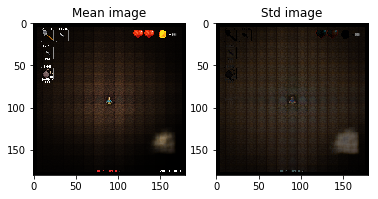

In [4]:
dset_mean = np.load("data/stats/dsetMean.npy")
dset_std = np.load("data/stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))

channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

torchchannel_means = torch.from_numpy(channel_means)
torchchannel_stds = torch.from_numpy(channel_stds)

# Compute and Display Saliency Maps

In [15]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    #X.requires_grad_()
    
    saliency = None
    split = (X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896])
    concat = torch.cat(split, dim=1)
    concat.requires_grad_()
    y_pred = model(concat)
    
    loss = y_pred.gather(1,y.view(-1,1)).squeeze() 
    loss.sum().backward()
    grad = concat.grad
    grad1 = grad[:,0:3,:,:]
    grad2 = grad[:,3:6,:,:]
    grad3 = grad[:,6:9,:,:]
    grad4 = grad[:,9:12,:,:]
    saliency1 = torch.max(torch.abs(grad1), 1)[0]
    saliency2 = torch.max(torch.abs(grad2), 1)[0]
    saliency3 = torch.max(torch.abs(grad3), 1)[0]
    saliency4 = torch.max(torch.abs(grad4), 1)[0]
    finalSaliency = torch.cat((saliency1,saliency2,saliency3,saliency4), dim=2)
    
    return finalSaliency

tensor([[-1.5418, -1.6942, -1.7979,  3.8128]])
tensor([ 3])
torch.Size([1, 12, 224, 224])
torch.Size([1, 224, 896])


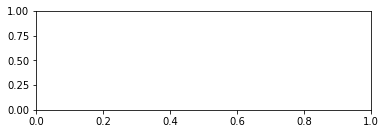

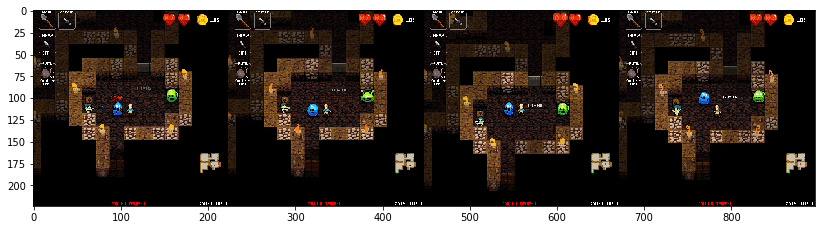

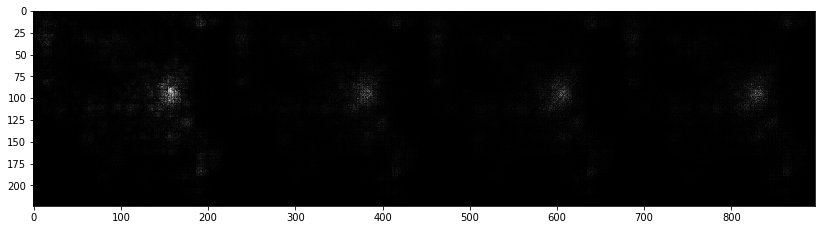

In [142]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = X#torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = y#torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    print(saliency.shape)
    N = X.shape[0]
    X = torch.transpose(torch.transpose(X, 1,3),1,2)
    for i in range(N):
        plt.subplot(2,1,1)
        #plt.subplot(2, N, i + 1)
        plt.figure(figsize=(14,10))
        plt.imshow(X[i].numpy()*channel_stds+channel_means, aspect='equal')
        plt.figure(figsize=(14,10))
        #result = Image.fromarray(saliency.numpy())

        #plt.axis('off')
        plt.subplot(2,1,2)
        plt.imshow(saliency[i].numpy(), aspect='equal')
        #plt.axis('off')
#         plt.figure(figsize=(14,10))
#         plt.subplot(3,1,3)
#         plt.imshow(X[i].numpy()*channel_stds+channel_means+ saliency[i][:,:,None], aspect='equal')
#         #plt.axis('off')
        
        image = Image.fromarray(saliency[i].numpy()*50000)
        image =image.convert('RGB')
        image.save('saliency.png')
    
    plt.show()


    
    
image_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(channel_means, channel_stds)
])


dataset = datasets.ImageFolder(root='data/classes/224scaledQuad', transform=image_transform)
num_images = len(dataset)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1,
                                           sampler=sampler.SubsetRandomSampler(range(num_images)))


wrongPrediction= True
numWrong = 0
while wrongPrediction:
    batch = next(iter(data_loader)) 
    
    X = batch[0]
    split = (X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896])
    concat = torch.cat(split, dim=1)
    y_pred = model(concat)
    
    print(y_pred)
    print(batch[1])
    if torch.argmax(y_pred) == batch[1].squeeze():
        wrongPrediction = False
    else:
        numWrong = numWrong+1
        print('got it wrong '+ str(numWrong))

show_saliency_maps(batch[0], batch[1])

# Also Occlusion Maps (*Much* More Expensive)

tensor([[-1.5585, -1.6221, -1.6654,  0.6782]])
tensor([[ 1.6256,  1.6135,  1.6081,  ...,  1.5900,  1.5957,  1.6258],
        [ 1.6228,  1.6153,  1.6134,  ...,  1.5877,  1.5941,  1.6242],
        [ 1.6322,  1.6239,  1.6194,  ...,  1.5869,  1.5949,  1.6247],
        ...,
        [ 1.6152,  1.6146,  1.6147,  ...,  1.6260,  1.6246,  1.6239],
        [ 1.6156,  1.6143,  1.6149,  ...,  1.6254,  1.6246,  1.6240],
        [ 1.6202,  1.6185,  1.6184,  ...,  1.6256,  1.6238,  1.6230]])


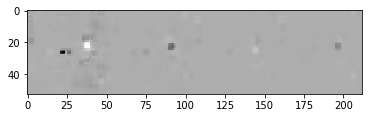

In [143]:
def occlusionHeatmap(X,y,boxSize=16,stride=4): #only takes one image
    deepX = torch.cat((X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896]),dim=1)
    grayBox = torch.ones([3,boxSize,boxSize])/2
    numHeight = int((deepX.shape[2]-boxSize)/stride)+1
    numWidth = int((deepX.shape[3]-boxSize)/stride)+1
    heatmap = torch.zeros([4,numHeight,numWidth])
    
    
    
    for depth in range(4):
        for height in range(numHeight):
            for width in range(numWidth):
                transformedX = deepX.clone()
                transformedX[:,depth*3:depth*3+3,height*stride:height*stride+boxSize,width*stride:width*stride+boxSize] = grayBox
                
#                 print(transformedX.mean())
#                 print(deepX.mean())
                #print(transformedX.shape)
                pred = model(transformedX)
#                 print(pred)
#                 print(pred[:,y])
                heatmap[depth,height,width] = pred[:,y]
    
    
    
    return torch.cat((heatmap[0],heatmap[1],heatmap[2],heatmap[3]),dim=1)

heatmap = occlusionHeatmap(batch[0],batch[1])
#print(heatmap.shape)
plt.imshow(heatmap)

#print(heatmap.numpy()/(torch.max(heatmap).numpy()))
X = batch[0] #fucking SPAGHET
baseline = model(torch.cat((X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896]),dim=1))


baseline = baseline-torch.min(heatmap)
heatmap = heatmap-torch.min(heatmap)

baseline = baseline/torch.max(heatmap)
print(baseline)
print(heatmap)
heatmap = heatmap/torch.max(heatmap)

image = Image.fromarray(heatmap.numpy(), mode='F')
#image =image.convert('F')
image.save('occlusion.tiff')

In [152]:
torch.set_printoptions(threshold=5000)
#print(heatmap[:,:53])

show_saliency_maps(batch[0], batch[1])

tensor([[ 0.6790,  0.6740,  0.6717,  0.6659,  0.6648,  0.6755,  0.6857,
          0.6881,  0.6948,  0.7020,  0.6846,  0.6779,  0.6759,  0.6761,
          0.6761,  0.6785,  0.6798,  0.6805,  0.6808,  0.6796,  0.6777,
          0.6769,  0.6761,  0.6763,  0.6774,  0.6787,  0.6791,  0.6776,
          0.6768,  0.6770,  0.6758,  0.6732,  0.6720,  0.6743,  0.6794,
          0.6800,  0.6699,  0.6814,  0.6809,  0.6814,  0.6601,  0.6521,
          0.6501,  0.6723,  0.6555,  0.6405,  0.6576,  0.6476,  0.6447,
          0.6698,  0.6902,  0.6917,  0.6823],
        [ 0.6778,  0.6747,  0.6739,  0.6758,  0.6800,  0.6817,  0.6881,
          0.6876,  0.6892,  0.6855,  0.6759,  0.6746,  0.6745,  0.6744,
          0.6739,  0.6768,  0.6791,  0.6789,  0.6785,  0.6767,  0.6749,
          0.6746,  0.6734,  0.6734,  0.6739,  0.6754,  0.6768,  0.6745,
          0.6741,  0.6742,  0.6739,  0.6711,  0.6711,  0.6739,  0.6790,
          0.6800,  0.6703,  0.6819,  0.6809,  0.6799,  0.6520,  0.6430,
          0.6438, 

# Try to Find Patterns in Conv Layers

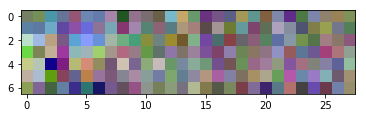

In [115]:
firstLayer = model.resnet.conv1.weight.data


individualFilter = firstLayer[18]
spreadOut = torch.cat((individualFilter[0:3],individualFilter[3:6],individualFilter[6:9],individualFilter[9:12]),dim=2)
spreadOut = torch.transpose(torch.transpose(spreadOut, 0,2),0,1)
#print(spreadOut.numpy()*channel_stds+channel_means)

maximum = torch.max(spreadOut)
minimum = torch.min(spreadOut)
finalImage = (spreadOut - minimum) / (maximum - minimum)
plt.imshow(finalImage)